### From previous Notebook we got to know LSTM is working well with this dataset

In [1]:
import pandas as pd
import numpy as np

import datetime
import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
import matplotlib.pylab as plt
from plotly.offline import plot
import chart_studio.plotly as py
import plotly.graph_objects as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

import tensorflow as tf
from tensorflow.keras.models import Sequential
from sklearn.linear_model import LinearRegression
from tensorflow.keras.layers import LSTM, GRU, Dropout, Dense

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score

**Data Ingestion**

In [2]:
# Reading all files

br = "D:/FSDS-iNeuron/10.Projects-DS/Investment_Prediction/pre_processed_dataset/britannia-industries.csv"
itc = "D:/FSDS-iNeuron/10.Projects-DS/Investment_Prediction/pre_processed_dataset/itc.csv"
rel = "D:/FSDS-iNeuron/10.Projects-DS/Investment_Prediction/pre_processed_dataset/reliance-industries.csv"
tcs = "D:/FSDS-iNeuron/10.Projects-DS/Investment_Prediction/pre_processed_dataset/tata-consultancy-services.csv"
tatam = "D:/FSDS-iNeuron/10.Projects-DS/Investment_Prediction/pre_processed_dataset/tata-motors-ltd.csv"

In [3]:
df_rel = pd.read_csv(rel, usecols = ['Date','Price'], index_col='Date')
df_rel.head(2)

,Price
Date,
2023-03-17,2223.1
2023-03-16,2225.9


**Report :**
Here, we have selected Price of stock which is daily Adj Close price.

#### Type of data

In [4]:
type(df_rel)

pandas.core.frame.DataFrame

In [5]:
df_br = pd.read_csv(br, usecols = ['Date','Price'], index_col='Date')
df_br.head(2)

,Price
Date,
2023-03-17,4362.55
2023-03-16,4311.20


In [6]:
df_itc = pd.read_csv(itc, usecols = ['Date','Price'], index_col='Date')
df_itc.head(2)

,Price
Date,
2023-03-17,375.55
2023-03-16,381.45


In [7]:
df_tcs = pd.read_csv(tcs, usecols = ['Date','Price'], index_col='Date')
df_tcs.head(2)

,Price
Date,
2023-03-17,3179.3
2023-03-16,3185.0


In [8]:
df_tatam = pd.read_csv(tatam, usecols = ['Date','Price'], index_col='Date')
df_tatam.head(2)

,Price
Date,
2023-03-17,419.0
2023-03-16,415.7


#### Preparing a list of dataframe

In [9]:
df_list = [df_br, df_itc, df_rel, df_tatam, df_tcs]

### Plotting SMA for individual stock

In [36]:
def plot_ma(df, window_size):
    plt.figure(figsize=(15,5))
    df['MA'] = df['Price'].rolling(window=window_size).mean()
    plt.plot(df['Price'], label='Price')
    plt.plot(df['MA'], label=f'{window_size}-day MA')
    plt.title(f"{window_size}-Day Moving Average Chart for Stock")
    plt.xlabel("Year")
    plt.ylabel("Price")
    plt.legend()
    plt.show()

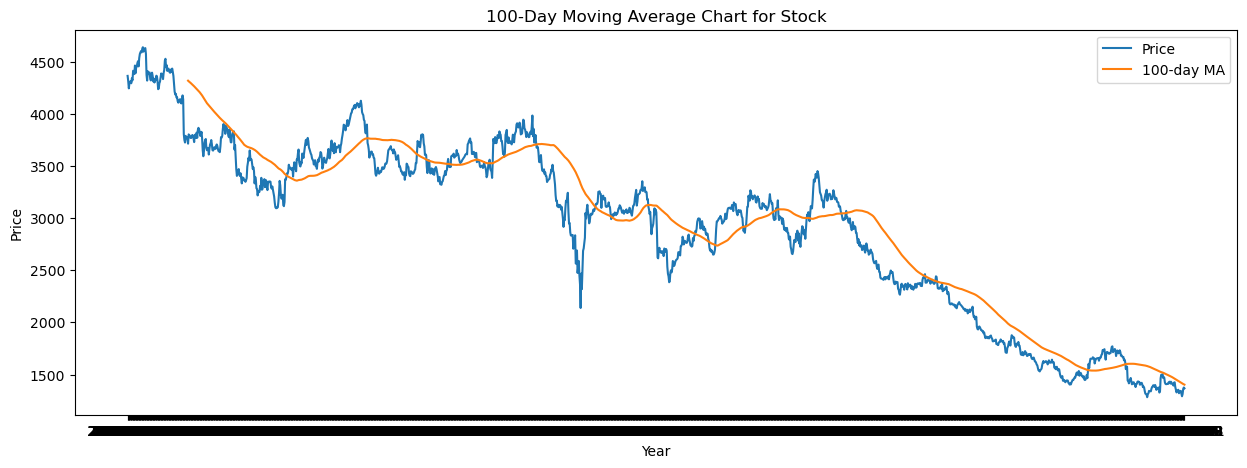

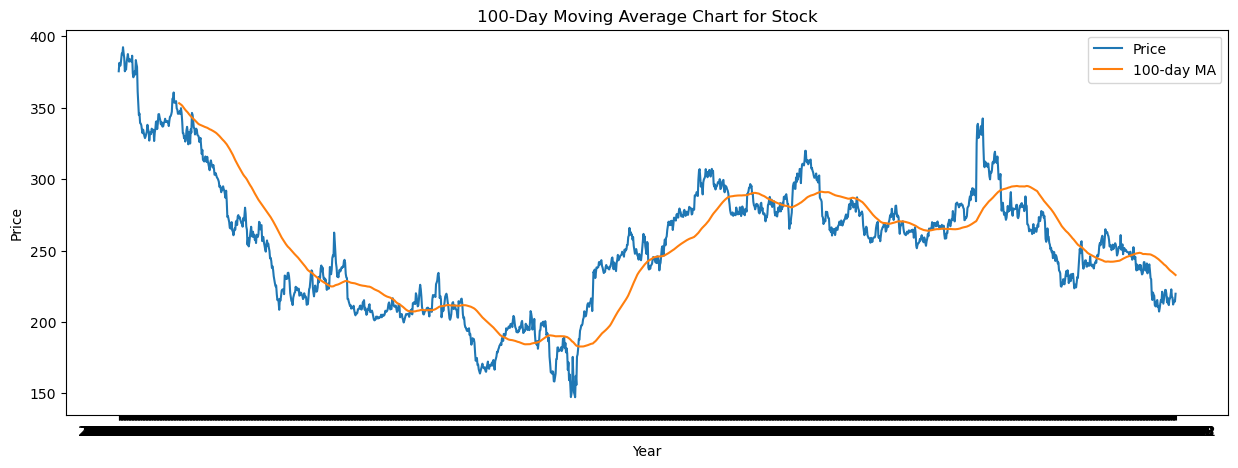

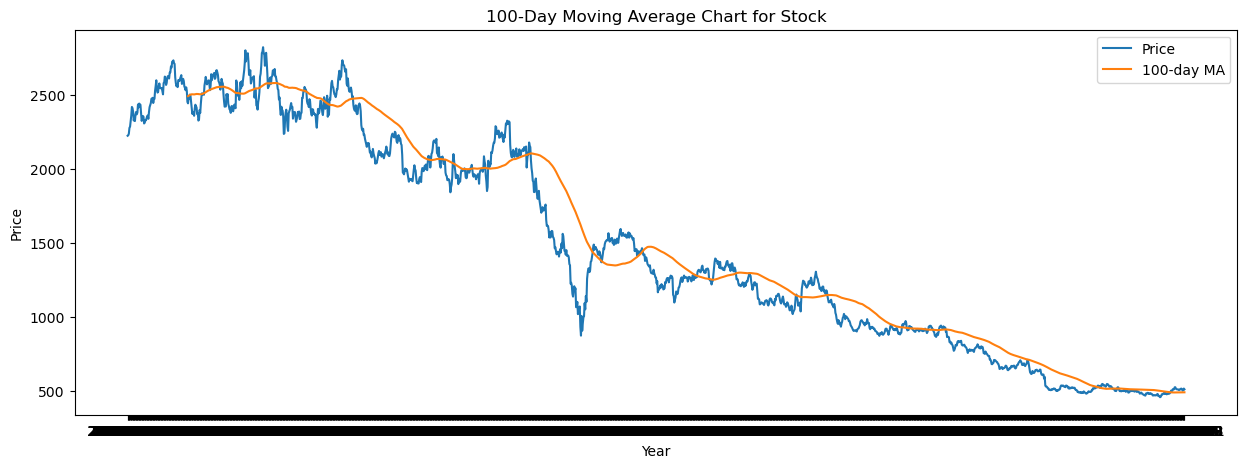

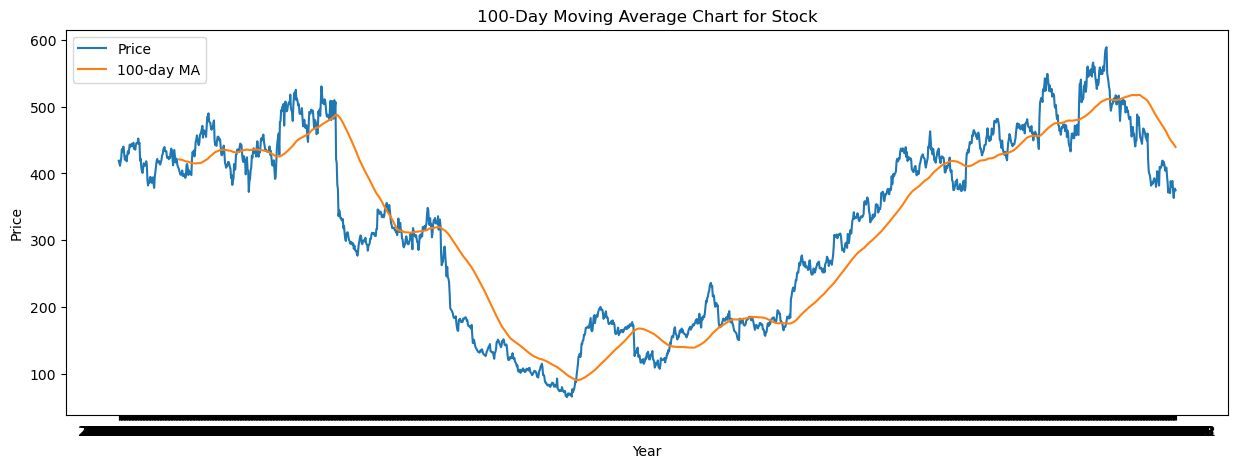

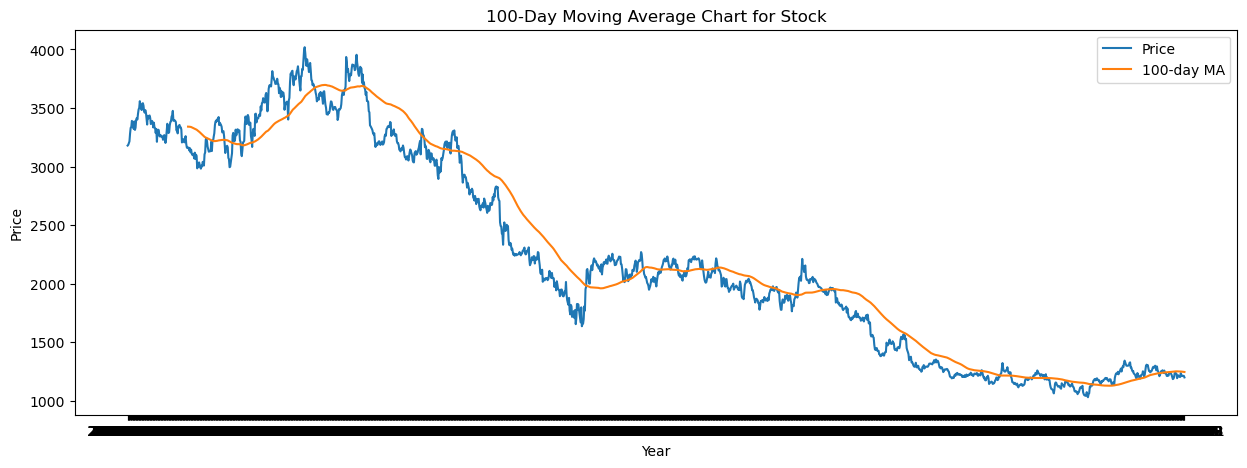

In [11]:
for df in df_list:
    plot_ma(df, 100)

### EMA

The formula for an **Exponential Moving Average (EMA)** is a bit more complex, as it places more weight on the most recent data points and less weight on older data points. The formula is as follows:

EMA = (closing price - EMA(previous day)) x (2 / n + 1) + EMA(previous day)

Where n is the number of periods (days in the case of stock prices) over which you want to calculate the EMA, and EMA(previous day) is the exponential moving average of the previous day. The number 2 / (n + 1) is the weight applied to the current day's price, with larger values of n giving more weight to older data points and smaller values of n giving more weight to recent data points.

### Plotting EMA for individual Stock

In [12]:
def plot_ema(df, window_size):
    ema = 'EMA'+f'{window_size}'
    df[ema] = df['Price'].ewm(span=window_size, adjust=False).mean()
    df[['Price', ema]].plot(figsize=(10,8))
    plt.xlabel("Year")
    plt.ylabel("Price")
    plt.legend()
    plt.show()

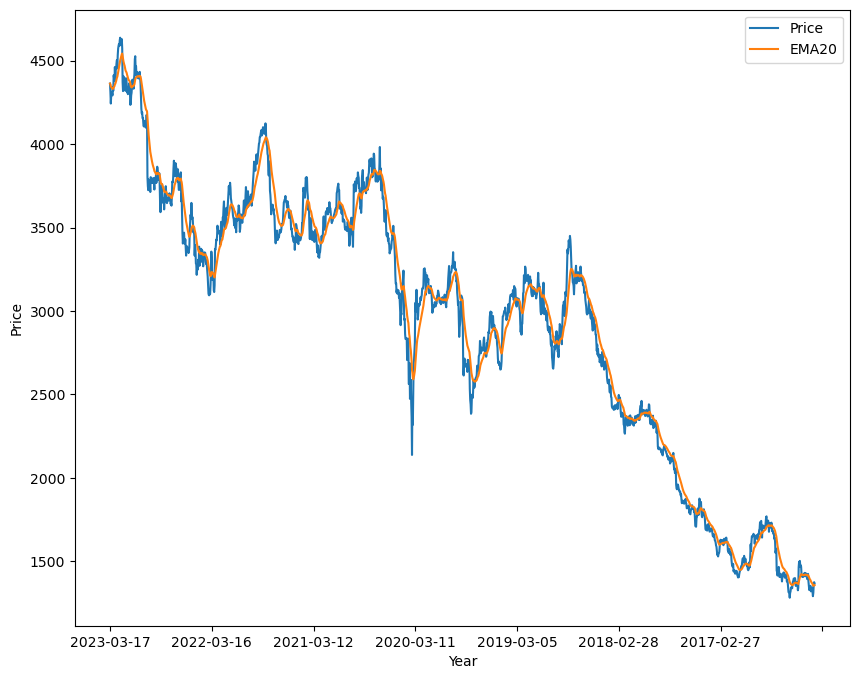

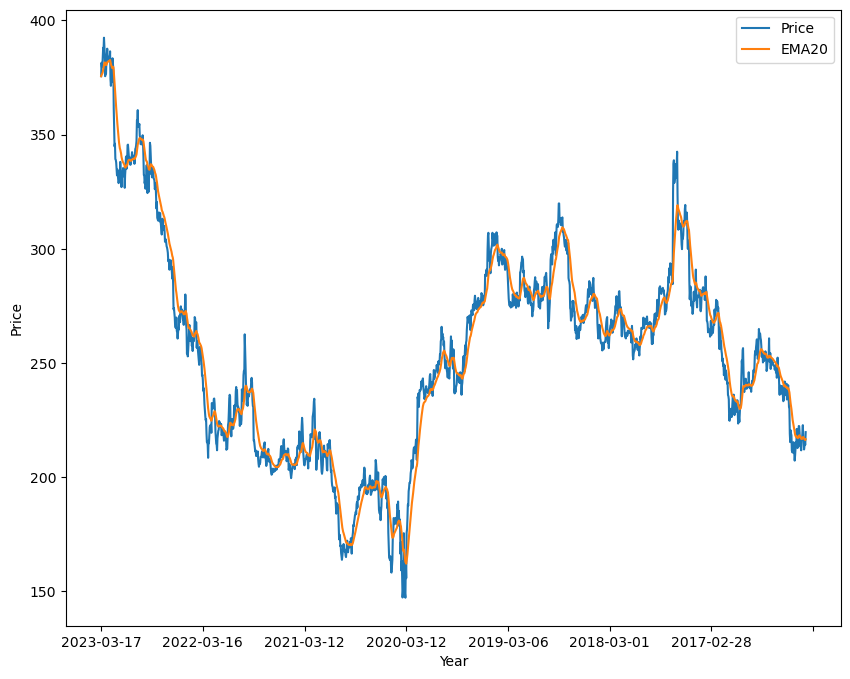

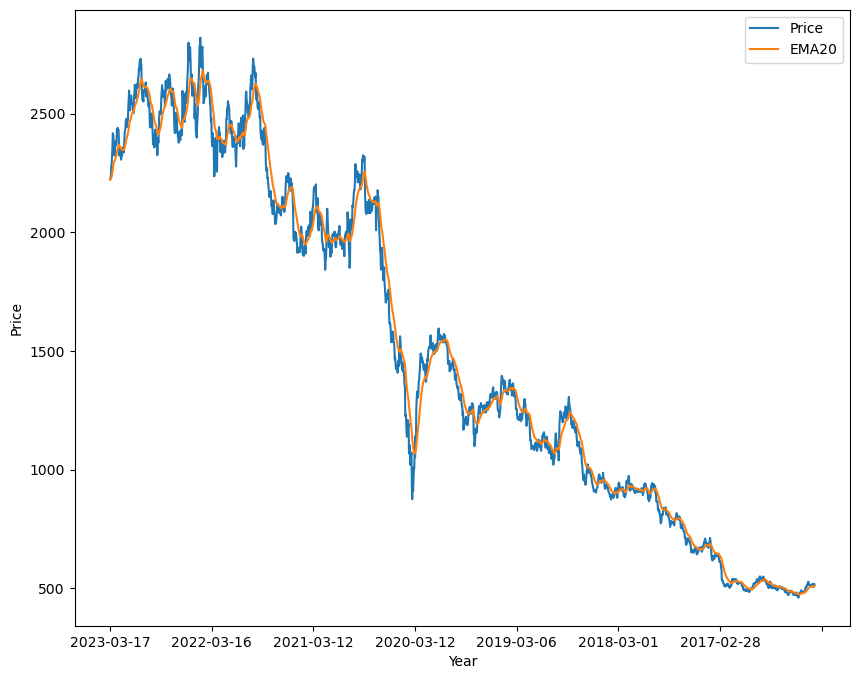

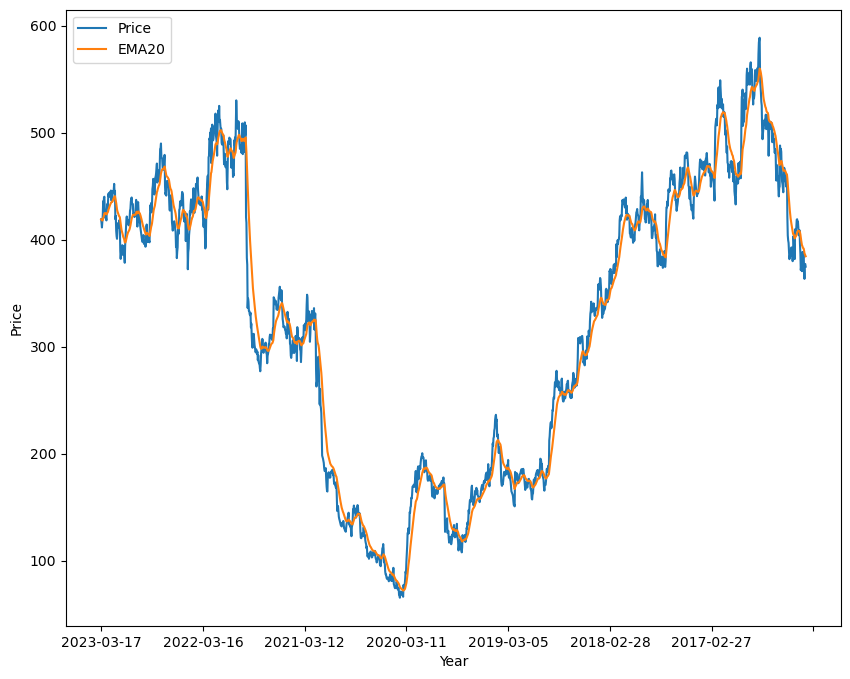

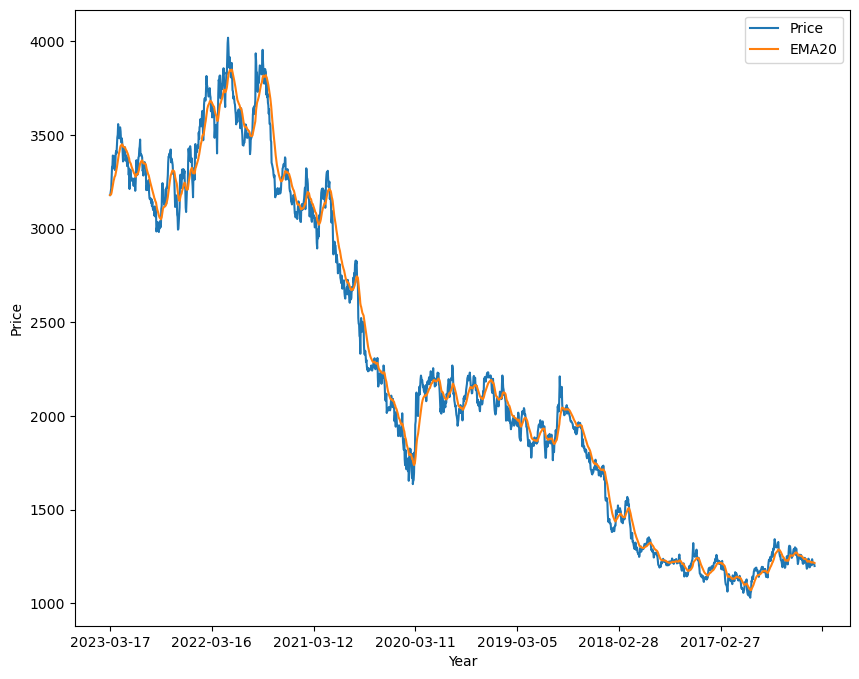

In [13]:
for df in df_list:
    plot_ema(df, 20)

### Plotting Bolinger Bands Chart

In [14]:
def plot_bollinger_band(df):
    plt.figure(figsize=(15,5))
    df['MA'] = df['Price'].rolling(window=20).mean()
    df['STD'] = df['Price'].rolling(window=20).std()
    df['Upper Band'] = df['MA'] + 2*df['STD']
    df['Lower Band'] = df['MA'] - 2*df['STD']
    plt.plot(df['Price'], label='Price')
    plt.plot(df['Upper Band'], label='Upper Band', linestyle='--')
    plt.plot(df['Lower Band'], label='Lower Band', linestyle='--')
    plt.title("Bollinger Bands Chart for Stock")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.show()

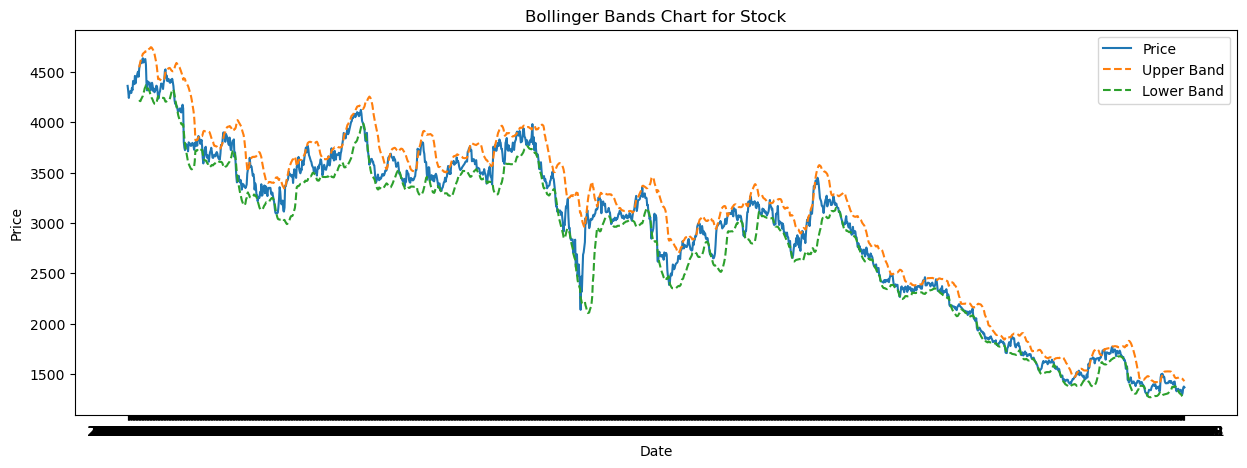

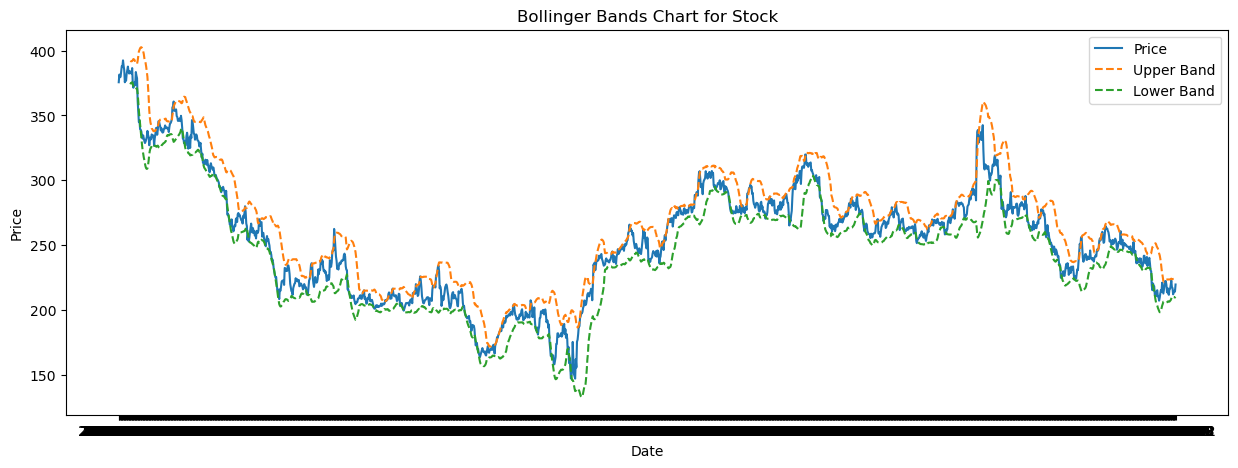

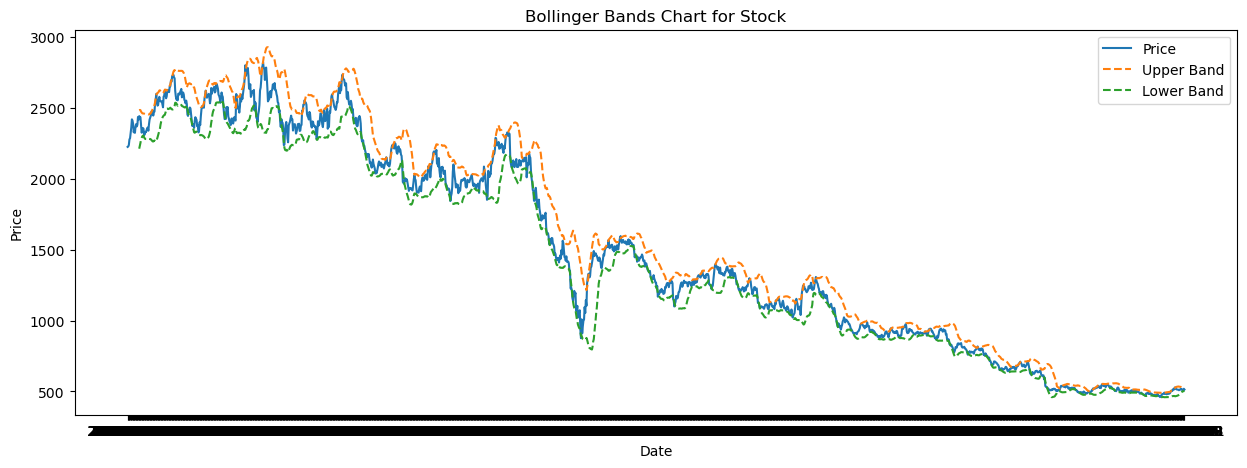

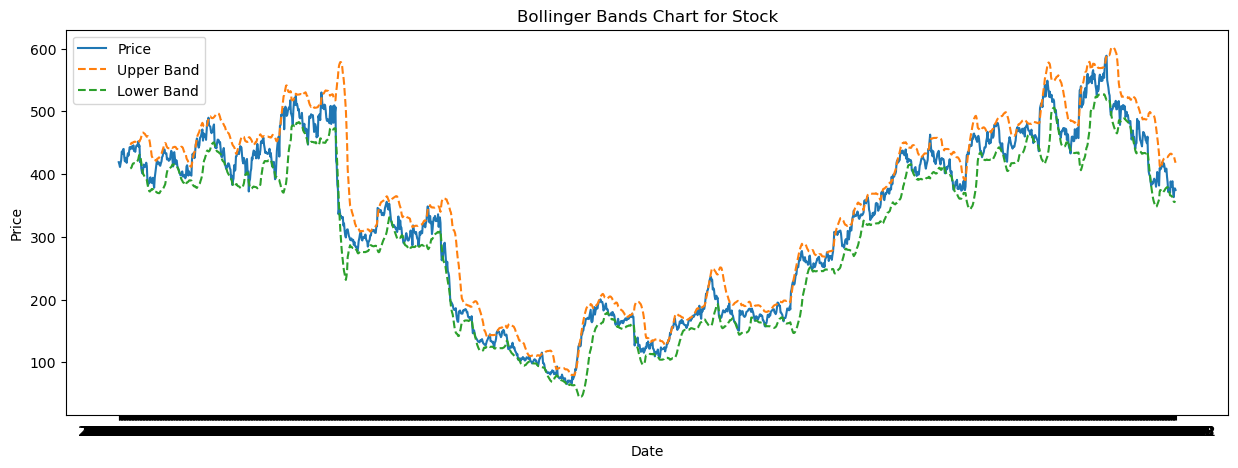

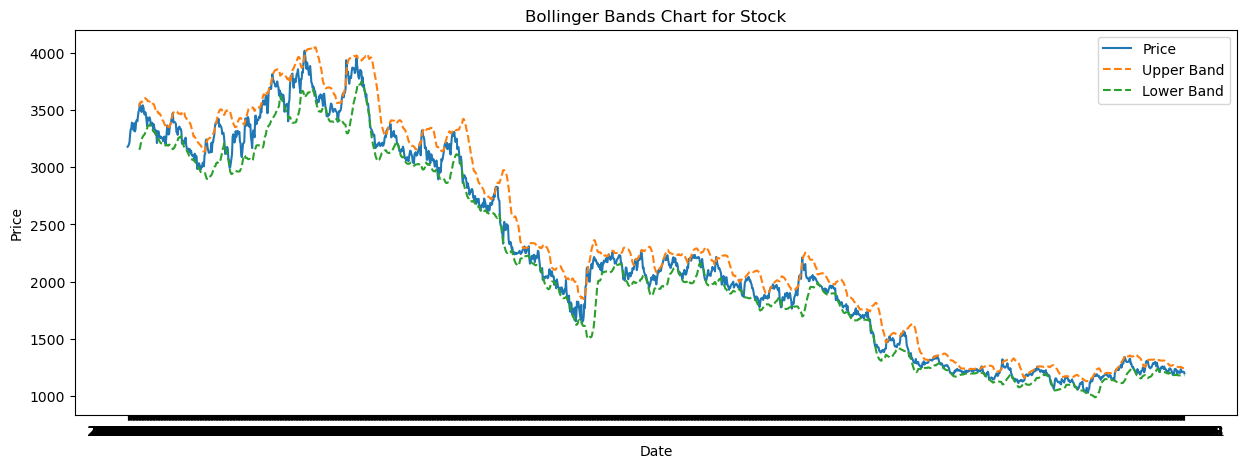

In [15]:
for df in df_list:
    plot_bollinger_band(df)

### MACD

In [16]:
def plot_macd(df):
    # Create the MACD line
    fast_period = 12
    slow_period = 26
    signal_period = 9
    df["MACD"] = df['Price'].ewm(span=fast_period, adjust=False).mean() - df['Price'].ewm(span=slow_period, adjust=False).mean()
    df["Signal"] = df["MACD"].ewm(span=signal_period, adjust=False).mean()

    # Plot the MACD chart
    plt.figure(figsize=(16, 8))
    plt.plot(df['Price'], label='Price')
    plt.plot(df["MACD"], label='MACD')
    plt.plot(df["Signal"], label='Signal')
    plt.legend(loc='best')
    plt.title("MACD Chart for Reliance")
    plt.show()

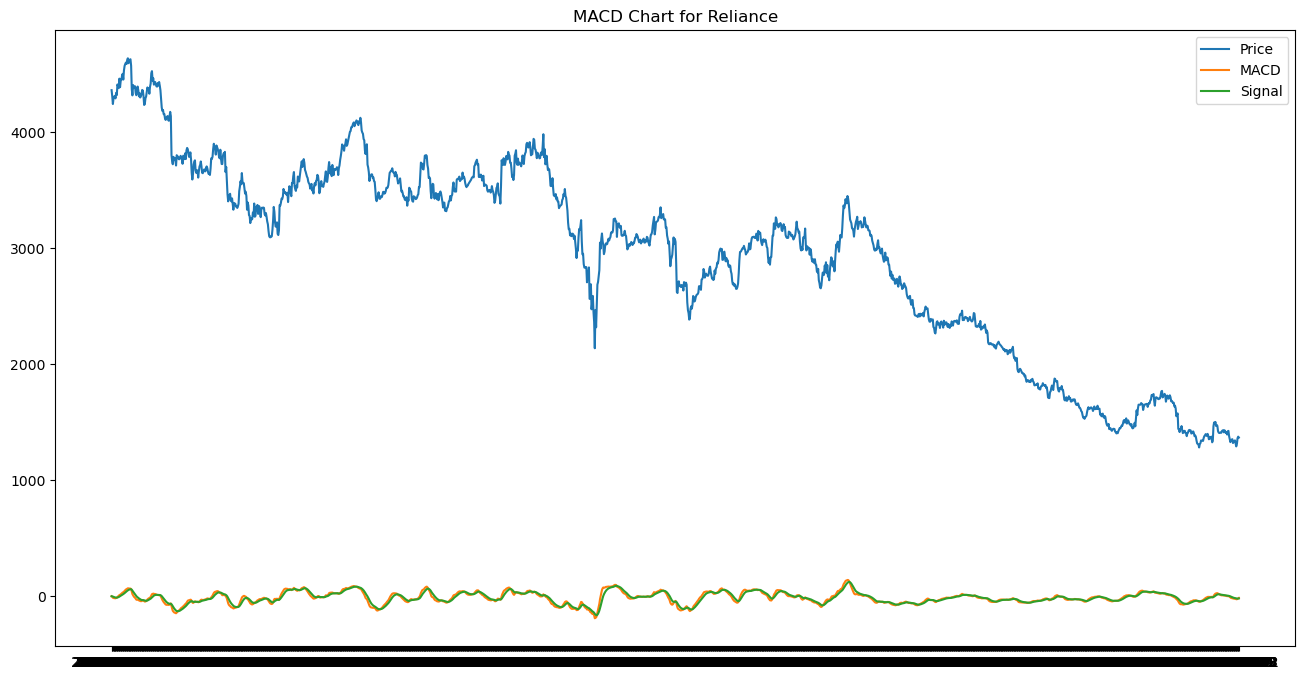

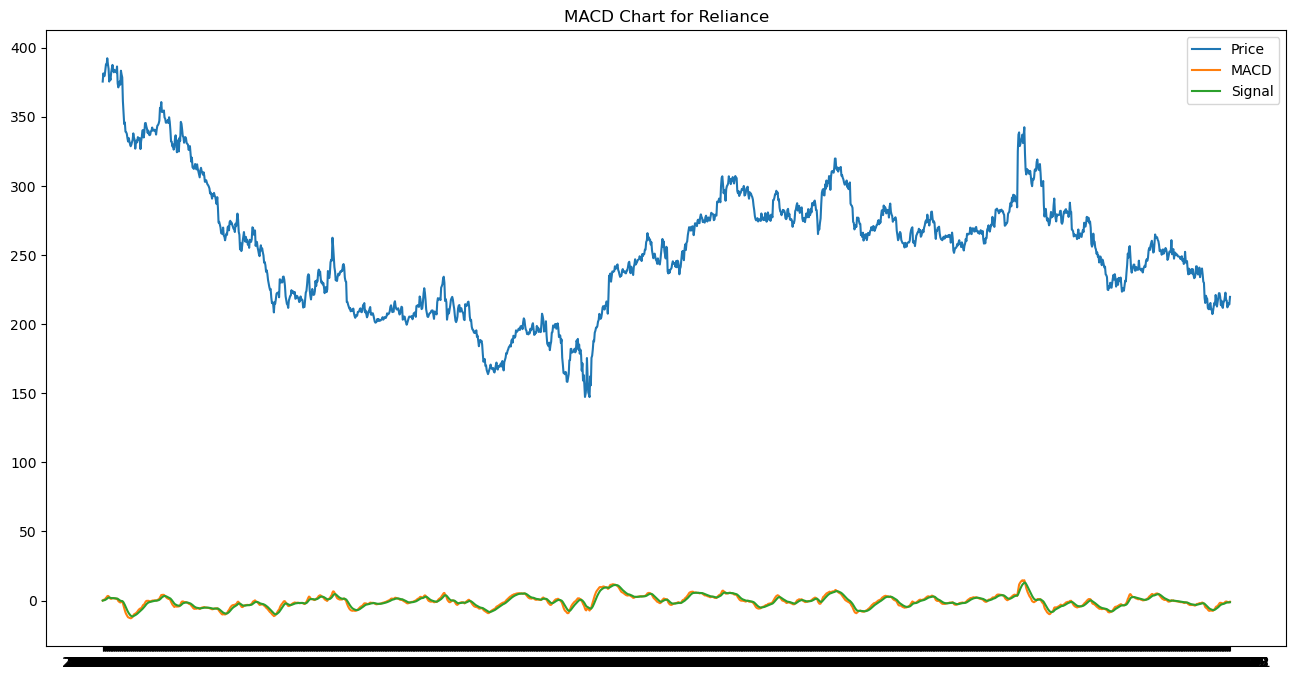

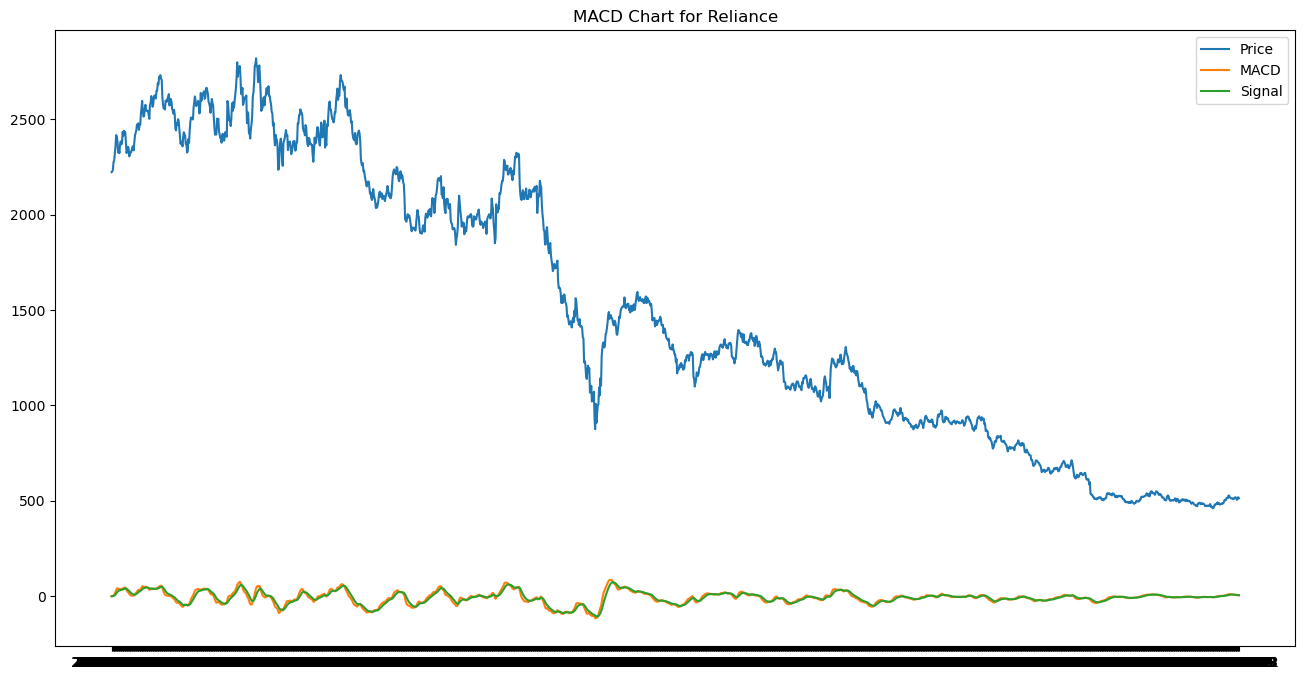

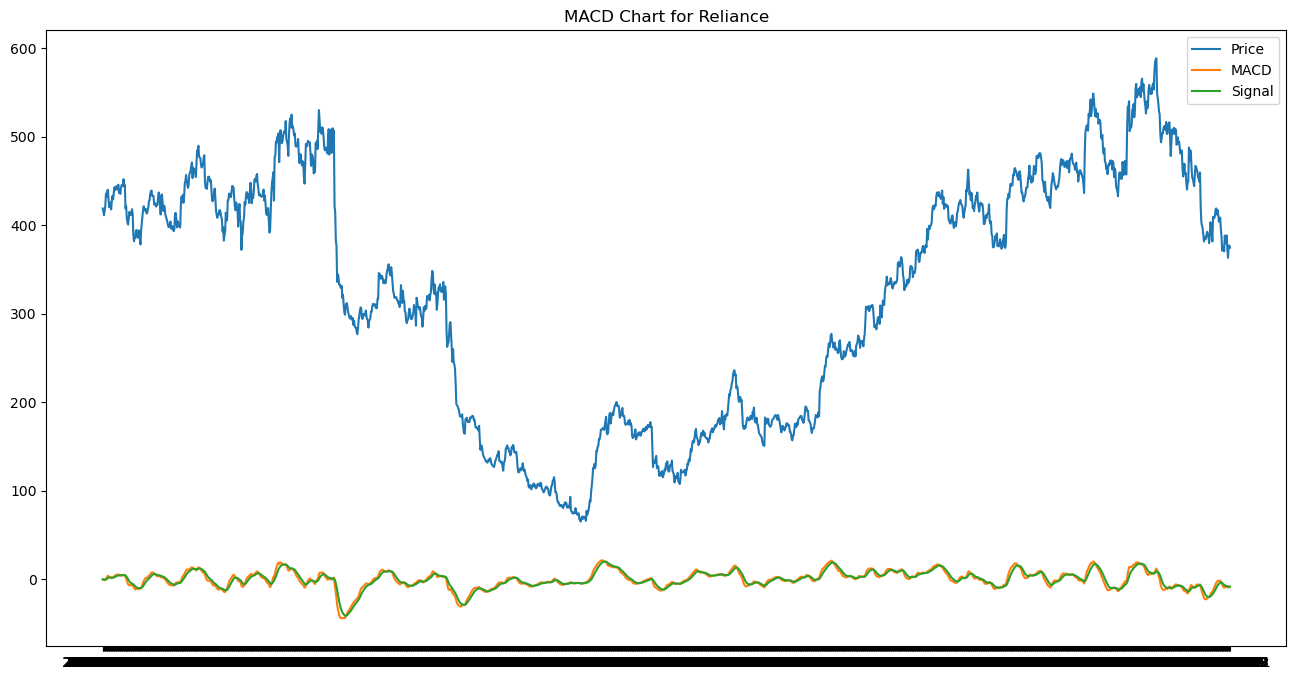

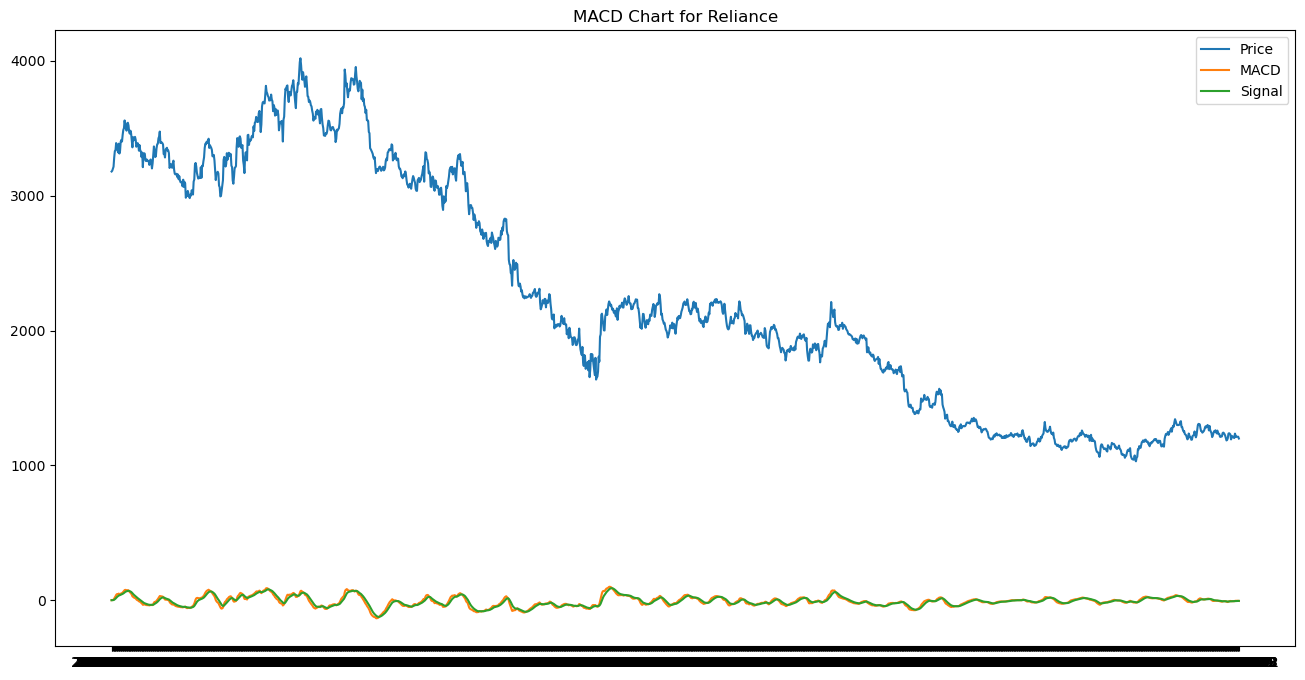

In [17]:
for df in df_list:
    plot_macd(df)

## Working with combined dataframe

In [10]:
## Combining all the data

df_combined = pd.concat([df_br['Price'], df_itc['Price'], df_rel['Price'], df_tatam['Price'], df_tcs['Price']], axis=1, join="inner", keys= ["Britannia", "ITC", "Reliance", "TATA_Motors", "TCS"])

In [11]:
df_combined.head()

,Britannia,ITC,Reliance,TATA_Motors,TCS
Date,,,,,
2023-03-17,4362.55,375.55,2223.10,419.00,3179.30
2023-03-16,4311.20,381.45,2225.90,415.70,3185.00
2023-03-15,4243.10,379.40,2237.05,411.35,3198.90
2023-03-14,4292.95,379.70,2275.95,416.65,3214.95
2023-03-13,4307.60,383.65,2284.50,422.40,3281.95


In [12]:
# Shape of the data

df_combined.shape

(1732, 5)

#### Column names

In [13]:
column_names = df_combined.columns
print(column_names)

Index(['Britannia', 'ITC', 'Reliance', 'TATA_Motors', 'TCS'], dtype='object')


#### Checking the correlation

In [14]:
df_combined.corr()

,Britannia,ITC,Reliance,TATA_Motors,TCS
Britannia,1.000000,0.050499,0.902172,-0.321406,0.861223
ITC,0.050499,1.000000,-0.008637,0.358467,-0.028162
Reliance,0.902172,-0.008637,1.000000,-0.063184,0.958077
TATA_Motors,-0.321406,0.358467,-0.063184,1.000000,-0.015433
TCS,0.861223,-0.028162,0.958077,-0.015433,1.000000


### Pairplot : To visualize each column data

<Figure size 2000x500 with 0 Axes>

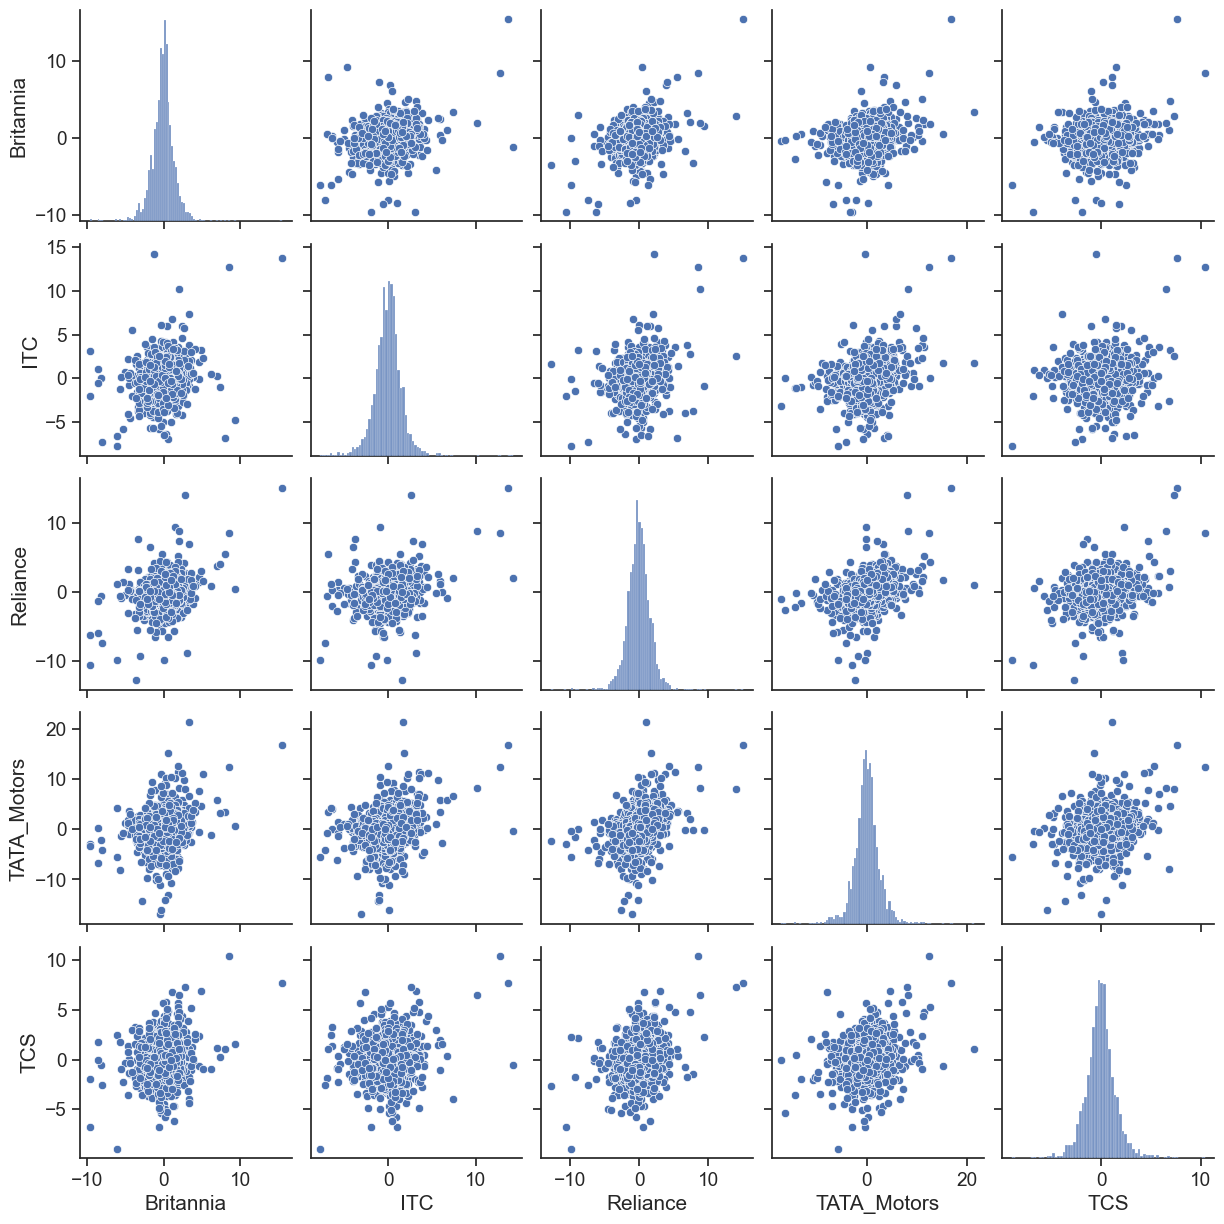

In [15]:
# store daily returns of all above stocks in a new dataframe

pct_chg_df = df_combined.pct_change()*100
pct_chg_df.dropna(inplace = True, how = 'any', axis = 0)

# plotting pairplot  

plt.figure(figsize = (20,5))
sns.set(style = 'ticks', font_scale = 1.25)
sns.pairplot(pct_chg_df)

**Correlation analysis is performed on the daily percentage change(daily returns) of the stock price and not on the stock price.**
- If you observe carefully, the plots in the lower triangular area are the same as the plots in the upper triangular area with just axes interchanged. So, analyzing either set of plots would suffice. The diagonal represents the histograms, just like the one seen above for ADANI Enterprises stock.
- Britannia, ITC, Reliance, Tata Motors, TCS can be included in a portfolio as no two stocks show any significant correlation.

#### Drawback of Correlation Plots:

Although the pair plots provide very good visualization of all possible combinations between the bunch of stocks, it doesn’t provide any detailed information like Pearson’s R value or null-hypothesis p value to quantify the correlation. That’s where the joint plot comes into the picture!

### SMA

Rolling Moving Average = sum of the last n closing prices / n

where n is the number of periods (days in the case of stock prices) over which you want to calculate the moving average.

In [24]:
def plot_combined_ma(df, window_size):
    # Calculate the simple moving average
    # Defining variables

    window_size_1 = window_size
    rolling_mean_1 = df_combined.rolling(window=window_size_1).mean()

    # Plot the moving averages
    plt.figure(figsize=(12, 8))
    for stock in df_combined.columns:
        plt.plot(df_combined[stock], label=f'{stock} Actual')
        plt.plot(rolling_mean_1[stock], label=f'{stock} Simple MA ({window_size_1} days)')
    #     plt.plot(rolling_mean_2[stock], label=f'{stock} Exponential MA ({window_size_2} days)')
    plt.legend()
    plt.title(f"Close Price and Moving Averages : {window_size_1} SMA")
    plt.xlabel("Year")
    plt.ylabel("Price")
    plt.show()

#### Plotting 50 Moving Average

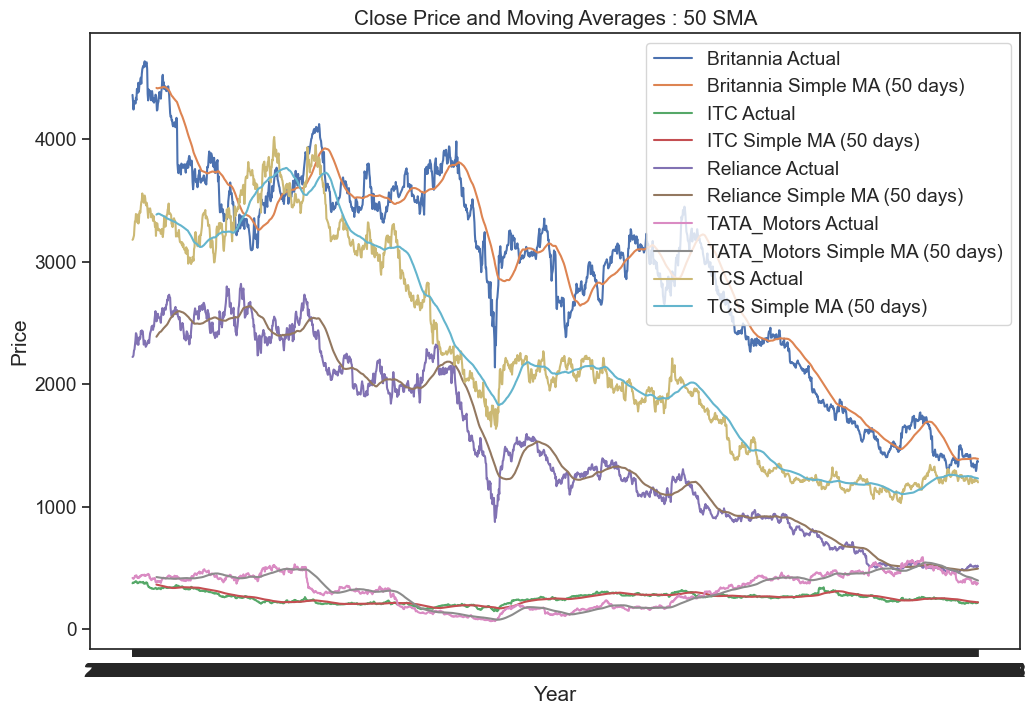

In [25]:
plot_combined_ma(df_combined, 50)

### EMA

In [26]:
def plot_combined_ema(df, window_size):
    # Calculate the exponential moving average
    window_size_2 = window_size
    rolling_mean_2 = df_combined.ewm(span=window_size_2).mean()

    plt.figure(figsize=(20,10))
    for stock in df.columns:
        plt.plot(df_combined[stock], label=f'{stock} Actual')
        plt.plot(rolling_mean_2[stock], label=f'{stock} EMA ({window_size_2} days)')
    plt.legend()
    plt.title(f"Close Price and Exponential Moving Average : {window_size_2} EMA")
    plt.xlabel("Year")
    plt.ylabel("Price")
    plt.show()


#### Plotting 50 EMA

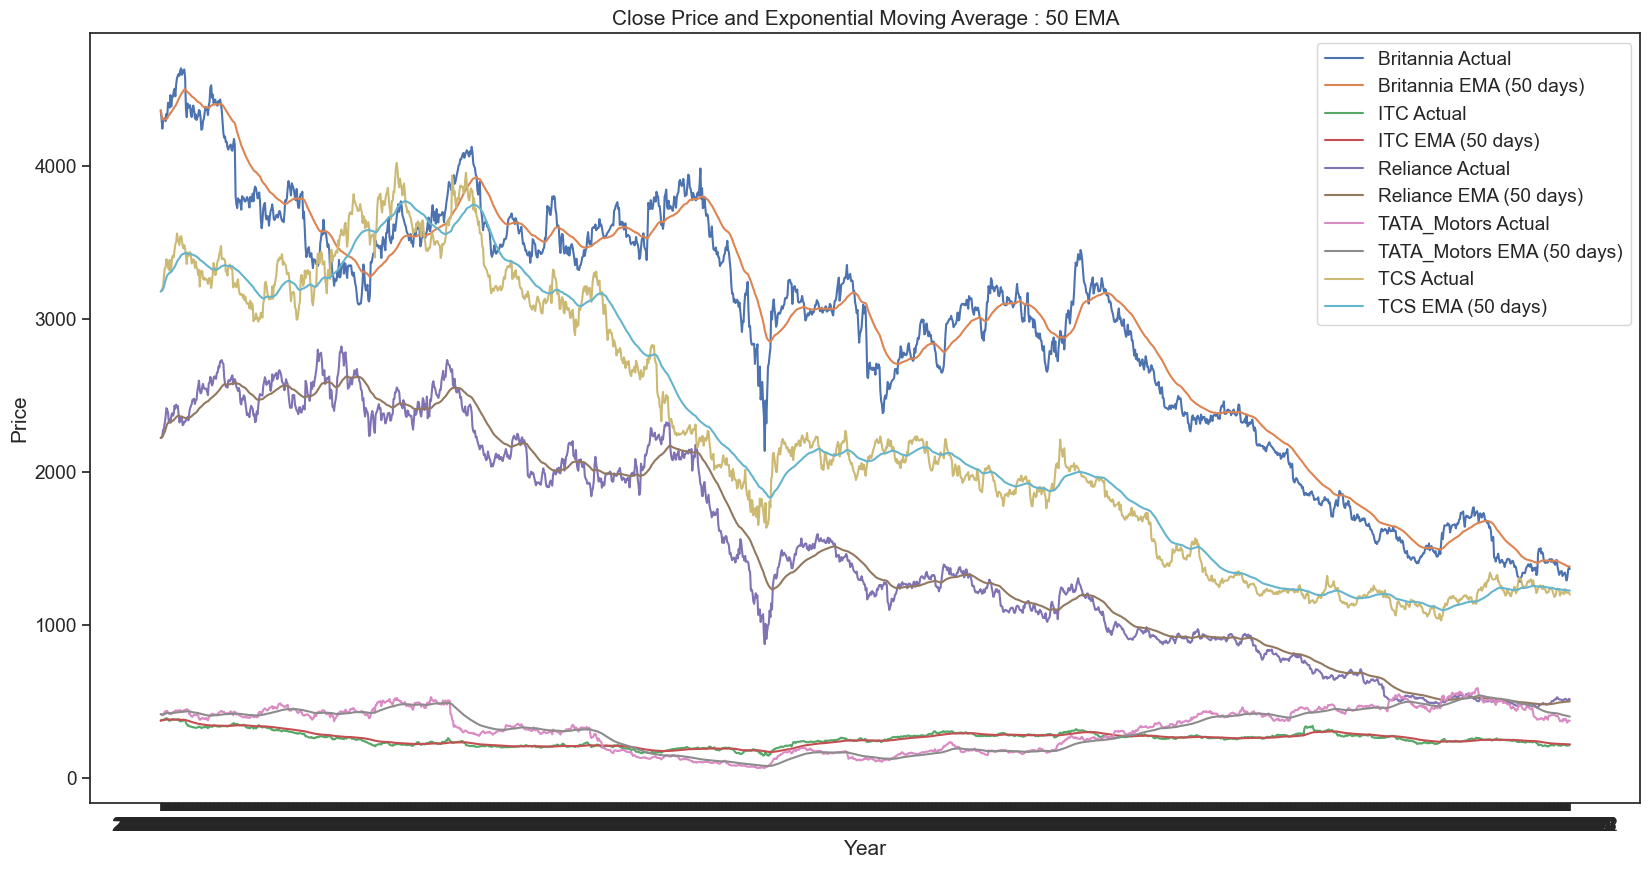

In [27]:
plot_combined_ema(df_combined, 50)

## Model Creation

In [16]:
df_combined.head()

,Britannia,ITC,Reliance,TATA_Motors,TCS
Date,,,,,
2023-03-17,4362.55,375.55,2223.10,419.00,3179.30
2023-03-16,4311.20,381.45,2225.90,415.70,3185.00
2023-03-15,4243.10,379.40,2237.05,411.35,3198.90
2023-03-14,4292.95,379.70,2275.95,416.65,3214.95
2023-03-13,4307.60,383.65,2284.50,422.40,3281.95


#### Making a copy of dataframe 

### Data Split

In [17]:
# Splitting data into a training set (80%) and a test set (20%) 

def split_data(X, test_size):
    X = X.values # Convert to NumPy array
    split = int(len(X) * (1-test_size))
    train_set = X[: split]
    test_set = X[split:]
    return train_set, test_set

In [18]:
test_size = 0.2
train_set, test_set = split_data(df_combined, test_size)

In [19]:
len(df_combined)

1732

In [20]:
train_set

array([[4362.55,  375.55, 2223.1 ,  419.  , 3179.3 ],
       [4311.2 ,  381.45, 2225.9 ,  415.7 , 3185.  ],
       [4243.1 ,  379.4 , 2237.05,  411.35, 3198.9 ],
       ...,
       [2125.72,  281.85,  780.3 ,  380.4 , 1232.33],
       [2125.25,  280.  ,  776.19,  385.3 , 1218.53],
       [2149.97,  279.2 ,  775.7 ,  389.25, 1221.82]])

In [21]:
test_set

array([[2080.  ,  271.25,  779.14,  375.4 , 1210.57],
       [2050.97,  271.5 ,  765.87,  374.5 , 1223.63],
       [2059.6 ,  273.1 ,  784.74,  380.2 , 1231.18],
       ...,
       [1362.65,  214.96,  509.77,  377.  , 1212.72],
       [1375.75,  214.23,  519.01,  377.2 , 1212.38],
       [1367.47,  219.74,  513.78,  374.7 , 1199.22]])

In [22]:
train_set.shape

(1385, 5)

In [23]:
test_set.shape

(347, 5)

**Supervised learning:**

Let us format the data in such a way that, supervised learning can be applied for ML model. Here, both the training set and test set will undergo the same transformation. We will achieve the objective with the below function.

In [24]:
def supvervisedSeries(data, n, h):
    x, y = [], []
    for i in range (len(data)-n-h+1):
        x.append(data[i:(i+n)])
        y.append(data[i+h+n-1])
    return np.array(x), np.array(y)

In [25]:
# h = time horizon & n = number of features; these parameters are chosen prior to transformation.

h = 1
n = 5
trainX, trainY = supvervisedSeries(train_set, n, h)
testX, testY = supvervisedSeries(test_set, n, h)

In [26]:
print("trainX: ", trainX.shape)
print("trainY: ", trainY.shape)
print("testX: ", testX.shape)
print("testY: ", testY.shape)

trainX:  (1380, 5, 5)
trainY:  (1380, 5)
testX:  (342, 5, 5)
testY:  (342, 5)


In [30]:
def reshape_Y(data):
    Y = np.reshape(data[:, 0], (data [:, 0].shape[0], 1))
    return Y

In [62]:
trainY = reshape_Y(trainY)
testY = reshape_Y(testY)
print('trainY: ', trainY.shape)
print("testY: ", testY.shape)

trainY:  (1380, 1)
testY:  (342, 1)


**Data Scaling :**

ML model require the data to lie within the range (0, 1). We have used MinMaxScaler which rescales the data set such that all feature values are in the range [0, 1]. It normally preserve the shape of the data set.

In [32]:
trainX.shape

(1380, 5, 5)

In [33]:
trainY.shape

(1380, 1)

In [34]:
trainX.shape[2]

5

In [35]:
def scale_feature(trainX, testX):
    scalers = {}
    for i in range (trainX.shape[2]):
        print(i)
        scalers[i] = StandardScaler()
        trainX[:, :, i] = scalers[i].fit_transform(trainX[:, :, i])
    for i in range(testX.shape[2]):
        testX[:, :, i] = scalers[i].transform(testX[:, :, i])
    return trainX, testX

In [36]:
trainX, testX = scale_feature(trainX, testX)

0
1
2
3
4


In [37]:
trainX.shape, testX.shape

((1380, 5, 5), (342, 5, 5))

In [38]:
trainY.shape, testY.shape

((1380, 1), (342, 1))

In [39]:
# The target values are 2D arrays, which is easy to scale
scalerY = StandardScaler()
trainY = scalerY.fit_transform(trainY)
testY = scalerY.transform(testY)

In [40]:
trainY.shape, testY.shape

((1380, 1), (342, 1))

**Feed Forward Neural Network:**

In below, only 100 neurons in each layer was used to deal with our small data set. Also, dropout as a regularization technique was used to reduce overfitting. The class Dense represents a fully connected layer.

In [41]:
trainX.shape, testX.shape

((1380, 5, 5), (342, 5, 5))

In [42]:
def flattern_input(X):
    n_input = X.shape[1] * X.shape[2]
    X = X.reshape((X.shape[0], n_input))
    return X

In [43]:
trainX = flattern_input(trainX)
testX = flattern_input(testX)

In [44]:
trainX.shape, testX.shape

((1380, 25), (342, 25))

In [45]:
trainX.shape[1]

25

In [46]:
# Create multilayered FFNN model
model = Sequential()

model.add(Dense(100, activation='relu', input_dim=trainX.shape[1]))
#model.add(Dropout(0.2))

model.add(Dense(100, activation='relu'))
#model.add(Dropout(0.2))

model.add(Dense(100, activation='relu'))
model.add(Dense(trainY.shape[1]))

model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               2600      
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 dense_2 (Dense)             (None, 100)               10100     
                                                                 
 dense_3 (Dense)             (None, 1)                 101       
                                                                 
Total params: 22,901
Trainable params: 22,901
Non-trainable params: 0
_________________________________________________________________


In [47]:
# Fit model
history = model.fit(trainX, trainY, epochs =60, verbose =1)

Epoch 1/60
44/44 [==============================] - 1s 3ms/step - loss: 0.1159
Epoch 2/60
44/44 [==============================] - 0s 3ms/step - loss: 0.0191
Epoch 3/60
44/44 [==============================] - 0s 3ms/step - loss: 0.0148
Epoch 4/60
44/44 [==============================] - 0s 3ms/step - loss: 0.0136
Epoch 5/60
44/44 [==============================] - 0s 3ms/step - loss: 0.0121
Epoch 6/60
44/44 [==============================] - 0s 3ms/step - loss: 0.0137
Epoch 7/60
44/44 [==============================] - 0s 3ms/step - loss: 0.0124
Epoch 8/60
44/44 [==============================] - 0s 3ms/step - loss: 0.0109
Epoch 9/60
44/44 [==============================] - 0s 3ms/step - loss: 0.0107
Epoch 10/60
44/44 [==============================] - 0s 3ms/step - loss: 0.0126
Epoch 11/60
44/44 [==============================] - 0s 3ms/step - loss: 0.0109
Epoch 12/60
44/44 [==============================] - 0s 3ms/step - loss: 0.0097
Epoch 13/60
44/44 [==============================

#### Plotting loss

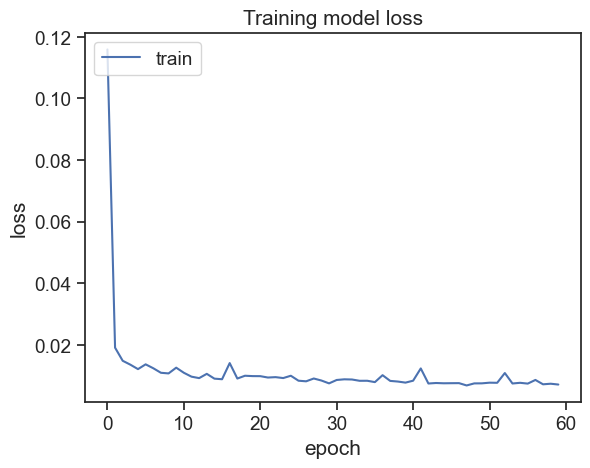

In [48]:
plt.plot(history.history['loss'])
plt.title('Training model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

Report :
- Loss decreased

### Validating model with test data

In [49]:
testX.shape, testY.shape

((342, 25), (342, 1))

#### Predicting output

In [50]:
y_pred_train = model.predict(trainX)
y_pred_train

44/44 [==============================] - 0s 2ms/step


array([[ 1.9427328],
       [ 1.9591126],
       [ 1.9402627],
       ...,
       [-2.0864482],
       [-2.0731735],
       [-2.0588794]], dtype=float32)

In [51]:
# Predict the test set
predictions = model.predict(testX)
predictions

11/11 [==============================] - 0s 2ms/step


array([[-2.1500552],
       [-2.1668568],
       [-2.2648623],
       [-2.3346353],
       [-2.3578188],
       [-2.3251305],
       [-2.3393476],
       [-2.350601 ],
       [-2.3643014],
       [-2.389994 ],
       [-2.388948 ],
       [-2.4064364],
       [-2.3955932],
       [-2.4144254],
       [-2.4222746],
       [-2.4594853],
       [-2.4774082],
       [-2.4678984],
       [-2.5015352],
       [-2.4828982],
       [-2.4720888],
       [-2.4581766],
       [-2.4769833],
       [-2.455535 ],
       [-2.4567022],
       [-2.4367428],
       [-2.4465652],
       [-2.483081 ],
       [-2.5131526],
       [-2.493925 ],
       [-2.520691 ],
       [-2.5530274],
       [-2.5732062],
       [-2.5576525],
       [-2.589808 ],
       [-2.5930855],
       [-2.6140184],
       [-2.6217577],
       [-2.60434  ],
       [-2.586034 ],
       [-2.5859206],
       [-2.5671763],
       [-2.5674286],
       [-2.5665736],
       [-2.574904 ],
       [-2.5484354],
       [-2.5491722],
       [-2.56

**Model Evaluation:**
We have to descale the data to bring back to original values using the same scaler that was originally used to scale the data.

In [52]:
def evaluation_train(y_actual, y_predict):
    print('-'*50)
    print("Train data RMSE: ", np.sqrt(mean_squared_error(y_actual,y_predict)))
    print("Train data MSE: ", mean_squared_error(y_actual,y_predict))
    print("Train data MAE: ", mean_absolute_error(y_actual,y_predict))
    print("Train data explained variance regression score:", explained_variance_score(y_actual, y_predict))
    print("Train data R2 score:", r2_score(y_actual, y_predict))
    print('-'*50)
    
def evaluation_test(y_actual, y_predict):
    print('-'*50)
    print("Test data RMSE: ", np.sqrt(mean_squared_error(y_actual,y_predict)))
    print("Test data MSE: ", mean_squared_error(y_actual,y_predict))
    print("Test data MAE: ", mean_absolute_error(y_actual,y_predict))
    print("Test data explained variance regression score:", explained_variance_score(y_actual, y_predict))
    print("Test data R2 score:", r2_score(y_actual, y_predict))   
    print('-'*50)

In [53]:
trainY.shape, y_pred_train.shape

((1380, 1), (1380, 1))

In [54]:
evaluation_train(trainY, y_pred_train)

--------------------------------------------------
Train data RMSE:  0.07541241420370398
Train data MSE:  0.005687032216031015
Train data MAE:  0.055633416768198225
Train data explained variance regression score: 0.9943767421014653
Train data R2 score: 0.9943129677839689
--------------------------------------------------


In [55]:
testY.shape, predictions.shape

((342, 1), (342, 1))

In [56]:
evaluation_test(testY, predictions)

--------------------------------------------------
Test data RMSE:  0.28367335376982394
Test data MSE:  0.08047057163901968
Test data MAE:  0.22548152937493837
Test data explained variance regression score: 0.7033537469713969
Test data R2 score: 0.2048769863833414
--------------------------------------------------


#### Getting the real data

In [57]:
def get_real_data(y_actual, y_pred):
    predicted_price = scalerY.inverse_transform(y_pred)
    actual_price = scalerY.inverse_transform(y_actual.reshape(-1,1)) 
    return actual_price, predicted_price, 

In [58]:
y_actual, y_pred = get_real_data(testY, predictions)

#### Plotting actual vs Predicted stock price  :  LSTM

In [59]:
def plot_actual_vs_predict(y_actual, y_predict):
    plt.plot(y_actual, color='red', label='Actual stock price')
    plt.plot(y_predict, color='green', label='Predicted stock price')
    plt.title('Stock price prediction')
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()

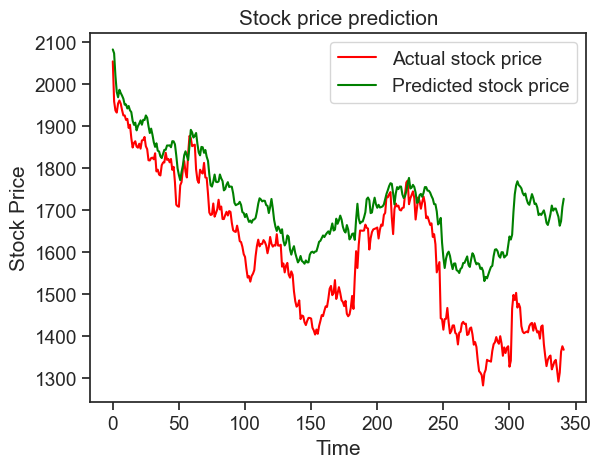

In [60]:
plot_actual_vs_predict(y_actual, y_pred)

In [61]:
y_pred

array([[2082.3774],
       [2073.168 ],
       [2019.4482],
       [1981.2036],
       [1968.496 ],
       [1986.4135],
       [1978.6206],
       [1972.4524],
       [1964.9427],
       [1950.8599],
       [1951.4332],
       [1941.8473],
       [1947.7908],
       [1937.4683],
       [1933.1659],
       [1912.7697],
       [1902.9456],
       [1908.1582],
       [1889.7208],
       [1899.9363],
       [1905.8612],
       [1913.4869],
       [1903.1785],
       [1914.9349],
       [1914.295 ],
       [1925.2355],
       [1919.8516],
       [1899.836 ],
       [1883.3529],
       [1893.8921],
       [1879.221 ],
       [1861.4965],
       [1850.4358],
       [1858.9613],
       [1841.3358],
       [1839.5393],
       [1828.0654],
       [1823.8232],
       [1833.3704],
       [1843.4044],
       [1843.4667],
       [1853.741 ],
       [1853.6027],
       [1854.0713],
       [1849.5052],
       [1864.0134],
       [1863.6096],
       [1856.4769],
       [1830.0469],
       [1799.1707],


In [57]:
# Descale
predictions = scalerY.inverse_transform(predictions)
testY = scalerY.inverse_transform(testY)
# Mean absolute error
mae = mean_absolute_error(testY, predictions)
print("Test MAE: %.6f" % mae)

Test MAE: 458.758142


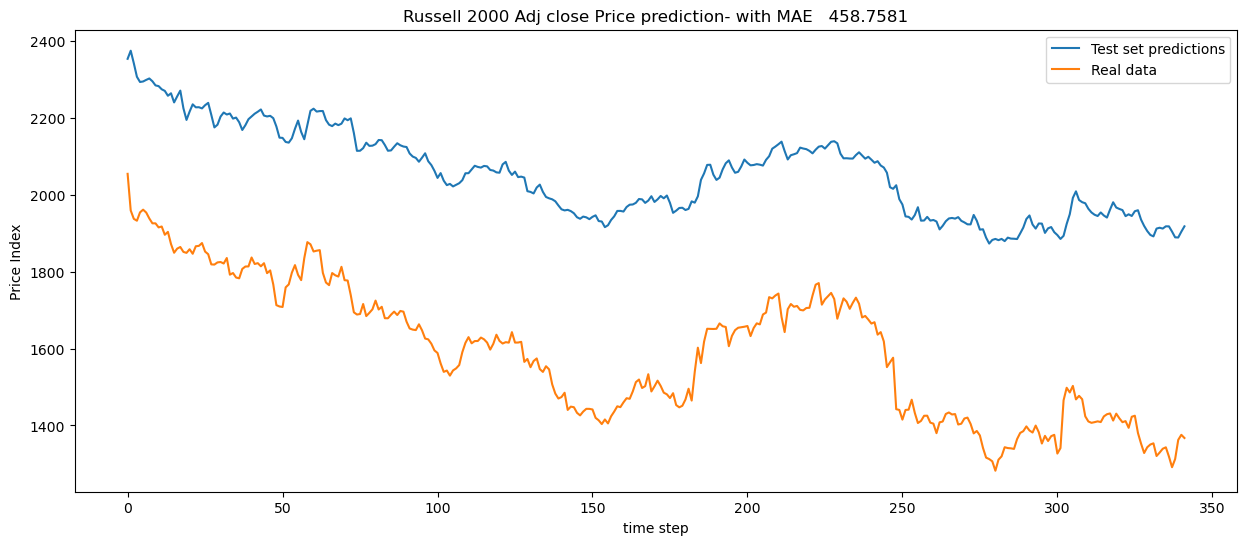

In [58]:
plt.figure(figsize=(15,6))
plt.plot(predictions, label="Test set predictions" )
plt.plot(testY, label="Real data")
plt.legend()
plt.ylabel('Price Index')
plt.xlabel('time step' )
plt.title ("Russell 2000 Adj close Price prediction- with MAE {:10.4f}".format(mae))
plt.show()